In [1]:
import os, glob, shutil, sys, copy, time, json, copy
from IPython import display
from tqdm import tqdm
from pycromanager import Acquisition, Bridge, Dataset, multi_d_acquisition_events
from skimage import io, img_as_ubyte, img_as_float, color, transform, exposure
from skimage.filters import threshold_mean
from skimage.measure import shannon_entropy
from skimage.util import view_as_windows
import imagej
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import norm
import scipy as sp
from shapely.geometry import mapping, shape
from tkinter import filedialog
import warnings

In [2]:
# os.environ['JAVA_MEM'] = '-Xmx4096m'
os.environ['_JAVA_OPTIONS']="-Xmx8g"
warnings.filterwarnings('ignore')

In [3]:
config = {
    "pixel-size-bf-20x" : 0.248,
    "pixel-size-bf-4x" : 1.26, # micron/pixel
    "pixel-size-shg" : 0.42,
    "camera-resolution" : (1392, 1040), # (width, height)
#    "camera-resolution" : (512, 512), # (width, height)
    "lsm-resolution-base" : (512, 512),  
    "slide-size" : (38000.0, 18000.0), # (width, height) (70000, -20000)
#    "slide-size" : (4000, 2000), # (width, height) (70000, -20000)
    "slide-start" : (0, 0), # x, y
    "Z-stage-20x" : -7500,
    "Z-stage-laser" : -5300,
    "Z-stage-4x" : -1050,
    "F-stage-20x" : -13000,
    "F-stage-laser" : -11000,
    "F-stage-4x" : -4000,
    "hard-limit-z" : (-7700.0, 17000.0),
    "hard-limit-x" : (-2000.0, 40000.0),
    "hard-limit-y" : (-2000, 20000.0),
    "hard-limit-f" : (-19000, 0),
    "focus-device" : 'ZStage:Z:32',
    "condensor-device" : 'ZStage:F:32',
    "led-device" : ('LED-Dev1ao0', 'Voltage'),
    "obj-device" : ('Turret:O:35', 'Label')
}

In [4]:
def generate_grid(config, mag='20x', mod='bf', box=None, overlap=50, xyz_pos_list=None, z_offset=0):
    if box is not None:
        s_x = box[0]
        s_y = box[1]
        e_x = box[2]
        e_y = box[3]
    else:
        s_x = config["slide-start"][0]
        s_y = config["slide-start"][1]
        e_x = config["slide-start"][0] + config["slide-size"][0]
        e_y = config["slide-start"][1] + config["slide-size"][1]
    if mod == 'bf':
        if mag == '20x':
            pixel_size = config["pixel-size-bf-20x"]
        if mag == '4x':
            pixel_size = config["pixel-size-bf-4x"]
        field_w = config["camera-resolution"][0] * pixel_size
        field_h = config["camera-resolution"][1] * pixel_size
    if mod == 'shg':
        if mag == '20x':
            pixel_size = config["pixel-size-shg"]
        if mag == '4x':
            raise ValueError('Not supported magnification for LSM')
        field_w = config["lsm-resolution-base"][0] * pixel_size
        field_h = config["lsm-resolution-base"][1] * pixel_size
    field_o = overlap * pixel_size
    grid_w = int(np.ceil((e_x - s_x) / (field_w - field_o)))
    grid_h = int(np.ceil((e_y - s_y) / (field_h - field_o)))
    if xyz_pos_list is not None:
        xy_pos_list = xyz_pos_list[:, :, :2] # x, y, z
        z_pos_list = xyz_pos_list[:, :, 2]
        list_w = xyz_pos_list[-1, -1, 0] - xyz_pos_list[0, 0, 0] # first pos
        list_h = xyz_pos_list[-1, -1, 1] - xyz_pos_list[0, 0, 1] # last pos
        resample_w = int(np.rint(list_w / 50))
        resample_h = int(np.rint(list_h / 50))
        dense_xy = transform.resize(xy_pos_list, (resample_h, resample_w), order=1)
        dense_z = transform.resize(z_pos_list, (resample_h, resample_w), order=3)
        dense_xyz = np.concatenate((dense_xy, dense_z[:, :, None]), axis=2)
        xy_list = np.zeros((grid_h, grid_w, 3))
    else:
        xy_list = np.zeros((grid_h, grid_w, 2))
    for x in range(grid_w):
        for y in range(grid_h):
            x_pos = x * (field_w - field_o) + s_x
            y_pos = y * (field_h - field_o) + s_y
            if xyz_pos_list is not None:
                x_idx = np.abs(dense_xyz[0, :, 0] - x_pos).argmin()
                y_idx = np.abs(dense_xyz[:, 0, 1] - y_pos).argmin()
                z_pos = dense_xyz[x_idx, y_idx, 2] + z_offset
                xy_list[y, x] = [x_pos, y_pos, z_pos]
            else:
                xy_list[y, x] = [x_pos, y_pos] # x, y
    return xy_list, (grid_h, grid_w) # row, col

def bounding_image(config, image):
        img_g = color.rgb2gray(img)
        img_t = transform.rescale(img_g, 0.1, anti_aliasing=None, order=0)
        thresh = threshold_mean(img_t)
        img_d = 1 - (img_t > thresh)
        imgh = np.sum(img_d, axis = 1)
        imgw = np.sum(img_d, axis = 0)
        imgh_m = np.mean(imgh)
        imgw_m = np.mean(imgw)
        box_s_x = min(np.argwhere(imgw>imgw_m*0.2))[0] * 10
        box_s_y = min(np.argwhere(imgh>imgh_m*0.2))[0] * 10
        box_e_x = max(np.argwhere(imgw>imgw_m*0.2))[0] * 10
        box_e_y = max(np.argwhere(imgh>imgh_m*0.2))[0] * 10
        start = config["slide-start"]
        low_box_bounded = (config["slide-start"][0] + config["pixel-size-bf-4x"] * box_s_x,
                           config["slide-start"][1] + config["pixel-size-bf-4x"] * box_s_y,
                           config["slide-start"][0] + config["pixel-size-bf-4x"] * box_e_x,
                           config["slide-start"][1] + config["pixel-size-bf-4x"] * box_e_y,
                          )
        fig, ax = plt.subplots(1)
        ax.imshow(img_t, cmap='gray')
        rect = patches.Rectangle((int(box_s_x/10),int(box_s_y/10)), int((box_e_x-box_s_x)/10), int((box_e_y-box_s_y)/10), linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.show()
        return low_box_bounded # bounding box in real stage position
    
def snap_image(core, rgb, flip_channel=True):
    core.snap_image()
    tagged_image = core.get_tagged_image()
    if rgb == True:
        pixels = np.reshape(
            tagged_image.pix,
            newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"], 4],
            )
    else:
        pixels = np.reshape(
            tagged_image.pix,
            newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"]],
            )
    pixels = pixels[:, :, 0:3]
    if flip_channel:
        pixels = np.flip(pixels, 2)
    return pixels

def whole_slide_scan(config, core=None, save_path=None, acq_name=None, position_list=None, z_positions=None, mda=False, z_stack=False, z_center=None, sample_depth=20, z_step=4, estimate_background=False, background_image=None, focus_dive=False):
    if mda == True:
        if z_positions is not None:
            position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2)
            if z_stack:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3), z_start=-int(sample_depth/2), z_end=int(sample_depth/2), z_step=z_step)
                    acq.acquire(events)      
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3))
                    acq.acquire(events)
        else:
            if z_stack:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2), z_start=-int(sample_depth/2) + z_center, z_end=int(sample_depth/2) + z_center, z_step=z_step)
                    acq.acquire(events)
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2))
                    acq.acquire(events)
    else:
        fig = plt.figure(figsize=(8, 6))
        plt.axis("off")
        show = plt.imshow(np.zeros((config["camera-resolution"][1], config["camera-resolution"][0])))
        acq_id = len(glob.glob(os.path.join(save_path, acq_name+"*")))
        acq_path = os.path.join(save_path, acq_name+"_{}".format(acq_id+1))
        os.makedirs(acq_path, exist_ok=True)
        if estimate_background:
            sum_img = np.zeros((config["camera-resolution"][1], config["camera-resolution"][0], 3))
            sum_count = 0
        if background_image is not None:
            bg_img = white_balance(copy.deepcopy(background_image), copy.deepcopy(background_image))
        if z_positions is not None:
            tile_count = 0
            core.set_focus_device(config["focus_device"])                
            position_list = np.concatenate((position_list, z_positions[:, :, None]), axis=2).reshape(position_list.shape[0], position_list.shape[1], 3)
            for pos_row in range(position_list.shape[0]):
                for pos_col in range(position_list.shape[1]):
                    z_pos = position_list[pos_row, pos_col, 2]
                    x_pos = position_list[pos_row, pos_col, 0]
                    y_pos = position_list[pos_row, pos_col, 1]
                    if (z_pos < config["hard-limit-z"][0] or z_pos > config["hard-limit-z"][1] 
                        or x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                        or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"])[1]:
                        print('position out of range')
                        break
                    core.set_position(z_pos)
                    core.set_xy_position(x_pos, y_pos)
                    xy_device = core.get_xy_stage_device()
                    z_device = core.get_focus_device()
                    core.wait_for_device(xy_device)
                    core.wait_for_device(z_device)
                    pixels = snap_image(core, rgb=True, flip_channel=True)
                    pixels = img_as_float(pixels)
                    if estimate_background:
                        print('background')
                        if is_background(pixels):
                            sum_img = sum_img + pixels
                            sum_count = sum_count + 1
                    if background_image is not None:
                        pixels = white_balance(pixels, background_image)
                        pixels = flat_field(pixels, bg_img)
                    show.set_data(pixels)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                    io.imsave(acq_path+'/{}_{}.tiff'.format(pos_row, pos_col), img_as_ubyte(pixels))
                    sys.stout.write('\r {}/{} tiles done'.format(tile_count, pos_row*pos_col))
                    
        if z_positions is None:
            tile_count = 0
            core.set_focus_device(config["focus_device"])
            position_list = position_list.reshape(position_list.shape[0], position_list.shape[1], 2)
            z_positions=np.ones(xy_positions.shape[0]) * core.get_position()
            for pos_row in range(position_list.shape[0]):
                for pos_col in range(position_list.shape[1]):
                    x_pos = position_list[pos_row, pos_col, 0]
                    y_pos = position_list[pos_row, pos_col, 1]
                    if ( x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                        or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"][1]):
                        print('position out of range')
                        break
                    core.set_xy_position(x_pos, y_pos)
                    xy_device = core.get_xy_stage_device()
                    core.wait_for_device(xy_device)
                    if focus_dive == True:
                        pixels = autofocus(core, method='entropy', rgb=True, search_range=45, crop_ratio=1.0, flip_channel=True)
                        z_positions[i] = pos_z
                    else:
                        pixels = snap_image(core, rgb=True, flip_channel=True)
                    pixels = img_as_float(pixels)
                    if estimate_background:
                        if is_background(pixels):
                            print('background')
                            sum_img = sum_img + pixels
                            sum_count = sum_count + 1
                    if background_image is not None:
                        pixels = white_balance(pixels, background_image)
                        pixels = flat_field(pixels, bg_img)
                    show.set_data(pixels)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)
                    io.imsave(acq_path+'/{}_{}.tiff'.format(pos_row, pos_col),img_as_ubyte(pixels))
                    sys.stout.write('\r {}/{} tiles done'.format(tile_count, pos_row*pos_col))
        returns = []
        if estimate_background:
            returns.append(sum_img / sum_count)
        if focus_dive:
            z_positions = z_positions.reshape(position_list.shape[0], position_list.shape[1])
            returns.append(z_positions)
        return tuple(returns)

In [5]:
def stitching(config, ij, save_path, acq_name, mod='bf', mag='4x', mda=True, z_stack=False, position_list=None, flip_x=False, flip_y=False, correction=False, background_image=None):
    position_list_flat = position_list.reshape(-1, 2)
    stitch_folder = os.path.join('data/stitching/tiles', acq_name)
    os.makedirs(stitch_folder, exist_ok=True)
    out_folder = os.path.join('data/stitching/stitched', acq_name)
    os.makedirs(out_folder, exist_ok=True)
    if mod == 'bf':
        if mag == '20x':
            pixel_size = config["pixel-size-bf-20x"]
        if mag == '4x':
            pixel_size = config["pixel-size-bf-4x"]
    else:
        pixel_size = config["pixel-size-shg"]
    if mda:
        data_path = glob.glob(save_path+'/'+acq_name+'*')[-1]
        dataset = Dataset(data_path)
    else:
        image_list = glob.glob(os.path.join(glob.glob(save_path+'/'+acq_name+'*')[-1], '*.tiff'))
        image_list.sort(key=lambda x: os.path.getmtime(x))
    if correction is True and background_image is not None:
        bg_img = white_balance(copy.deepcopy(background_image), copy.deepcopy(background_image))
    with open(os.path.join(stitch_folder, 'TileConfiguration.txt'), 'w') as text_file:
        if z_stack:
            print('dim = {}'.format(3), file=text_file)
        else:
            print('dim = {}'.format(2), file=text_file)
        for pos_row in range(position_list.shape[0]):
            for pos_col in range(position_list.shape[1]):
                x = int(position_list[pos_row, pos_col, 0] / pixel_size)
                y = int(position_list[pos_row, pos_col, 1] / pixel_size)
                if z_stack:
                    print('{}_{}.tiff; ; ({}, {}, {})'.format(pos_row, (position_list.shape[1] - pos_col), x, y, 0), file=text_file)
                    z_idx = 0
                    img_z_list = []
                    while(dataset.has_image(position=pos_row*position_list.shape[1]+pos_col, z=z_idx)):
                        img_z_list.append(dataset.read_image(position=pos_row*position_list.shape[1]+pos_col, z=z_idx))
                        z_idx = z_idx+1
                    img = np.stack(img_z_list, axis=0)
                else:    
                    print('{}_{}.tiff; ; ({}, {})'.format(pos_row, (position_list.shape[1] - pos_col), x, y), file=text_file)
                    if mda:
                        img = dataset.read_image(position=pos_row*position_list.shape[1]+pos_col)
                    else:
                        img = io.imread(image_list[pos_row*position_list.shape[1]+pos_col])
                    if correction is True and background_image is not None:
                        img = white_balance(img, background_image)
                        img = flat_field(img, bg_img)
                if flip_y:
                    img = img[::-1, :]
                if flip_x:
                    img = img[:, ::-1]
                io.imsave(stitch_folder+'/{}_{}.tiff'.format(pos_row, (position_list.shape[1] - pos_col)), img_as_ubyte(img))
    sys.stdout.write('stitching, please wait...')
    temp_channel_folder = 'data/stitching/channel_temp'
    os.makedirs(temp_channel_folder, exist_ok=True)
    params = {'type': 'Positions from file', 'order': 'Defined by TileConfiguration', 
            'directory':stitch_folder, 'ayout_file': 'TileConfiguration.txt', 
            'fusion_method': 'Linear Blending', 'regression_threshold': '0.30', 
            'max/avg_displacement_threshold':'2.50', 'absolute_displacement_threshold': '3.50', 
            'compute_overlap':False, 'computation_parameters': 'Save computation time (but use more RAM)', 
            'image_output': 'Write to disk', 'output_directory': temp_channel_folder}
    plugin = "Grid/Collection stitching"
    ij.py.run_plugin(plugin, params)
    if mod == 'bf':
        list_channels = [f for f in os.listdir(temp_channel_folder)]
        if z_stack:
            fused_list = []
            for channel in list_channels:
                fused_list.append(io.imread(os.path.join(temp_channel_folder, channel)))
            img_to_save = np.stack(fused_list, axis=0)
        else:
            if len(list_channels) == 1:
                img_to_save = io.imread(os.path.join(temp_channel_folder, list_channels[0]))
            else:
                c1 = io.imread(os.path.join(temp_channel_folder, list_channels[0]))
                c2 = io.imread(os.path.join(temp_channel_folder, list_channels[1]))
                c3 = io.imread(os.path.join(temp_channel_folder, list_channels[2]))
                img_to_save = np.stack((c1, c2, c3)).transpose((1, 2, 0))
        io.imsave(os.path.join(out_folder, 'fused.tiff'), img_as_ubyte(img_to_save))
    shutil.rmtree(temp_channel_folder)

In [6]:
def switch_objective(config, mag='4x'): # brightfield
    if mag == '4x':
        core.set_property('Turret:O:35', 'Label', 'Position-2')
        core.set_focus_device(config["condensor-device"])
        core.set_position(config["F-stage-4x"])
        core.set_focus_device(config["focus_device"])
        core.set_position(config["Z-stage-4x"])
        core.set_property(config["led-device"][0], config["led-device"][1], 5.0)
        core.wait_for_system()
    if mag == '20x':
        core.set_property(config["obj-device"][0], config["obj-device"][1], 'Position-1')
        core.set_focus_device(config["condensor-device"])
        core.set_position(config["F-stage-20x"])
        core.wait_for_system()
        core.set_focus_device(config["focus-device"])
        core.set_position(config["Z-stage-20x"])
        core.set_property(config["led-device"][0], config["led-device"][1], 5.0)
        core.wait_for_system() 
        
def switch_mod(config, mod='shg'):
    current_objective = core.get_property('Turret:O:35', 'Label')
    if mod == 'shg':
        if current_objective == 'Position-2':
            print('Not supported magnification for LSM')
            core.set_property(config["obj-device"][0], config["obj-device"][1], 'Position-1')
            core.wait_for_system()
        core.set_property('Turret:O:35', 'Label', 'Position-1')
        core.set_focus_device(config["condensor-device"])
        core.set_position(config["F-stage-laser"]) # new value
        core.set_focus_device(config["focus-device"])
        core.set_position(config["Z-stage-laser"]) #
        core.set_property(config["led-device"][0], config["led-device"][1], 0.0)
        core.set_config('Imaging', 'LSM')
        core.set_property(config["led-device"][0], config["led-device"][1], 0.0)
        core.wait_for_system()
        print('Imaging mode set as SHG')
    if mod == 'bf':
        core.set_config('Imaging', 'Camera')
        if current_objective == 'Position-2':
            switch_objective(config, '4x')
        if current_objective == 'Position-1': 
            switch_objective(config, '20x')  
        print('Imaging mode set as Brightfield')

In [58]:
def is_background(img, t=10):
#     img = transform.resize(img, (1024, 1024))
    img = color.rgb2hsv(img)
    img_windows = np.squeeze(view_as_windows(img, (256, 256, 3), step=256))
    empty=True
    img_windows = np.reshape(img_windows, (img_windows.shape[0]*img_windows.shape[1], 256, 256, 3)) # nxm, 256, 256, 3
    img_max = np.max(img_windows, axis=0) # 256x256x3
    sat_img = img_max[:, :, 1]
    ave_sat = np.sum(sat_img)/(256*256)
#     print(ave_sat)
    return ave_sat < 0.30
#     img_gray = color.rgb2gray(color.rgba2rgb(img))
#     etp = shannon_entropy(img_gray)
#     img = color.rgb2hsv(img)
#     h, w, c = img.shape
#     sat_img = img[:, :, 1]
#     sat_img = img_as_ubyte(sat_img)
#     ave_sat = np.sum(sat_img)/(h*w)
#     return ave_sat < 2*t and etp < t

def estimate_background(config, save_path, acq_name, position_list=None, mda=True):
    sum_img = np.zeros((config["camera-resolution"][0], config["camera-resolution"][1], 3))
    sum_count = 0
    if mda:
        data_path = glob.glob(save_path+'/'+acq_name+'*')[-1]
        dataset = Dataset(data_path)
    else:
        image_list = glob.glob(os.path.join(glob.glob(save_path+'/'+acq_name+'*')[-1], '*.tiff'))
    for pos_row in range(position_list.shape[0]):
        for pos_col in range(position_list.shape[1]):
            if mda:
                img = dataset.read_image(position=pos_row*position_list.shape[1]+pos_col)
            else:
                img = io.imread(image_list[pos_row*position_list.shape[1]+pos_col])
            if is_background(img):
                sum_img = np.array(img_as_float(img)) + sum_img
                sum_count = sum_count + 1
    return sum_img / sum_count

def white_balance(img, bg, gain=1.0):
    img = img_as_float(img)
    bg = img_as_float(bg)
    r = np.mean(bg[:, :, 0])
    g = np.mean(bg[:, :, 1])
    b = np.mean(bg[:, :, 2])
    mm = max(r, g, b)
    img[:, :, 0] = np.clip(img[:, :, 0] * mm / r * gain, 0, 1)
    img[:, :, 1] = np.clip(img[:, :, 1] * mm / g * gain, 0, 1)
    img[:, :, 2] = np.clip(img[:, :, 2] * mm / b * gain, 0, 1)
    return img

def flat_field(img, bg, gain=1):
    img = img_as_float(img)
    bg = img_as_float(bg)
    r = np.mean(bg[:, :, 0])
    g = np.mean(bg[:, :, 1])
    b = np.mean(bg[:, :, 2])
    img[:, :, 0] = 1 * exposure.rescale_intensity(np.clip(np.divide(img[:, :, 0], bg[:, :, 0] + 0.00) * r * gain, 0, 1), in_range=(0, 0.85), out_range=(0, 1))
    img[:, :, 1] = 1 * exposure.rescale_intensity(np.clip(np.divide(img[:, :, 1], bg[:, :, 1] + 0.00) * g * gain, 0, 1), in_range=(0, 0.85), out_range=(0, 1))
    img[:, :, 2] = 1 * exposure.rescale_intensity(np.clip(np.divide(img[:, :, 2], bg[:, :, 2] + 0.00) * b * gain, 0, 1), in_range=(0, 0.85), out_range=(0, 1))
    return img

In [9]:
bridge = Bridge()
core = bridge.get_core()

In [10]:
core.set_timeout_ms(20000)

In [61]:
switch_objective(config, '20x')

In [81]:
switch_mod(config, mod='shg')

Imaging mode set as SHG


In [12]:
save_path = 'data/acquisition'
acq_name = 'slide-color-test'

In [13]:
position_list, grid = generate_grid(config, mag='4x', box=(5000, 5000, 20000, 15000))
# position_list, grid = generate_grid(config, mag='4x')
position_list.shape

(9, 10, 2)

In [76]:
position_list, grid = generate_grid(config, mag='20x',  mod='shg', box=(19500, 12500, 23500, 15500))
# position_list, grid = generate_grid(config, mag='4x')
position_list.shape

(8, 10, 2)

In [77]:
position_list

array([[[19500.  , 12500.  ],
        [19909.08, 12500.  ],
        [20318.16, 12500.  ],
        [20727.24, 12500.  ],
        [21136.32, 12500.  ],
        [21545.4 , 12500.  ],
        [21954.48, 12500.  ],
        [22363.56, 12500.  ],
        [22772.64, 12500.  ],
        [23181.72, 12500.  ]],

       [[19500.  , 12909.08],
        [19909.08, 12909.08],
        [20318.16, 12909.08],
        [20727.24, 12909.08],
        [21136.32, 12909.08],
        [21545.4 , 12909.08],
        [21954.48, 12909.08],
        [22363.56, 12909.08],
        [22772.64, 12909.08],
        [23181.72, 12909.08]],

       [[19500.  , 13318.16],
        [19909.08, 13318.16],
        [20318.16, 13318.16],
        [20727.24, 13318.16],
        [21136.32, 13318.16],
        [21545.4 , 13318.16],
        [21954.48, 13318.16],
        [22363.56, 13318.16],
        [22772.64, 13318.16],
        [23181.72, 13318.16]],

       [[19500.  , 13727.24],
        [19909.08, 13727.24],
        [20318.16, 13727.24],
    

In [78]:
core.set_focus_device('ZStage:Z:32')
current_z = core.get_position()
whole_slide_scan(config, save_path, acq_name, position_list=position_list, mda=True, z_stack=True, z_center=current_z, core=core)

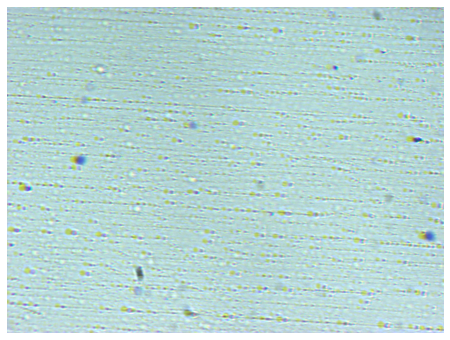

In [48]:
bg_img = whole_slide_scan(config, save_path, acq_name, position_list=position_list, mda=False, core=core, estimate_background=True)

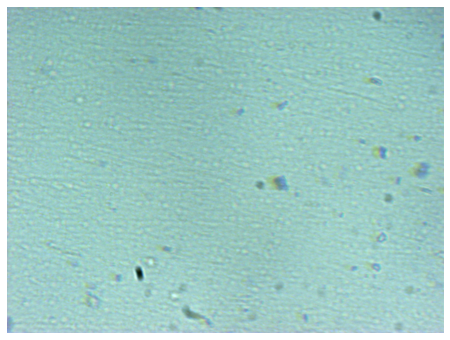

In [49]:
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(bg_img, out_range=(0, 1)))
plt.axis("off")
plt.show()

In [40]:
ij = imagej.init('fiji\\fiji\\Fiji.app')

In [59]:
Image.MAX_IMAGE_PIXELS = None  
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=False, position_list=position_list, flip_y=True, correction=True, background_image=bg_img)

stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-color-test\0_10.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (98 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\slide-color-test\0_9.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (95 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: 

In [97]:
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=True, z_stack=True, position_list=position_list, flip_y=True, correction=True)

Dataset opened of 1
stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\smart-wsi-scanner\data\stitching\tiles\slide-color-test\0_10.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] TiffDelegateReader initializing D:\experiments\smart-wsi-scanner\data\stitching\tiles\slide-color-test\0_10.tiff
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] dimension order is not certain, assuming XYZ instead of XYT[java.lang.Enum.toString] 
[java.lang.Enum.toString] 512x512x6px, channels=1, timepoints=1 (62 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: D:\experiments\sm

In [26]:
Image.MAX_IMAGE_PIXELS = None        
img = io.imread('example/BIC14011b.jpg')

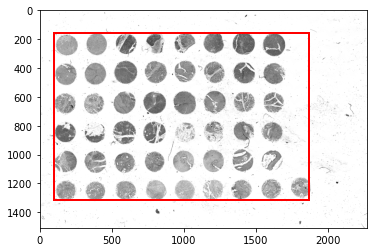

(2250.0, 3555.0, 42007.5, 29632.5)

In [67]:
bounding_box_4x = bounding_image(config, img)

In [83]:
# optimal 5085
core.set_position(4969)

In [84]:
core.get_position()

4969

In [85]:
autofocus(core, search_range=90)

4929
17.64436457496112
4939
17.65342005021535
4949
17.661655348030425
4959
17.668416834855833
4969
17.674633440854986
4979
17.67761608605648
4989
17.67937351747418
4999
17.67871046983665
72


4992.797468354431

In [43]:
def autofocus(core, method='entropy', rgb=True, search_range=45, crop_ratio=1.0, flip_channel=True):
    core.set_focus_device(config["focus_device"])   
    current_z = core.get_position()
    interval_z = int(search_range/9)
    scores = []
    positions = []
    count = 0
    for step in range(-4, 4):
        position_z = step * interval_z + current_z
        if position_z < -3000.0 or position_z > 22000.0:
            break
        core.set_position(position_z)
        core.wait_for_system()
        count = count + 1
        if is_background:
            return current_z
        pixels = snap_image(core, rgb, flip_channel=True)
        img_gray = color.rgb2gray(color.rgba2rgb(pixels))
        if method == 'entropy':
            score = shannon_entropy(img_gray)
        scores.append(score)
        positions.append(position_z)
    scores_array = np.asarray(scores)
    positions_array = np.asarray(positions)
    
    new_length = len(positions) * 10
    new_x = np.linspace(positions_array.min(), positions_array.max(), new_length)
    new_y = sp.interpolate.interp1d(positions_array, scores_array, kind='cubic')(new_x)
    idx = np.argmax(new_y)
    focus_z = new_x[idx]
    core.set_position(position_z)
    pixels = snap_image(core, rbg, flip_channel=True)
    return focus_z, pixels

def focus_dive(core, position_list, search_range=45, resample_grid_size=None):
    xy_positions=position_list.reshape(-1, 2)
    z_positions=np.ones(xy_positions.shape[0]) * core.get_position()
    for i in tqdm(range(xy_positions.shape[0])):
        # check hard limit
        position = xy_positions[i]
        core.set_xy_position(position[0], position[1])
        core.wait_for_system()
        pos_z = autofocus(core, search_range=search_range)
        core.set_position(pos_z)
        core.wait_for_system()
        z_positions[i] = pos_z
    position_list_z = z_positions.reshape(position_list.shape[0], position_list.shape[1])
    return position_list_z

In [41]:
def extract_rois(config, annotation_path, image_size, mag='4x'):
    rois = []
    with open(annotation_path) as json_file:
        instances = json.load(json_file)
        for instance in instances:
            roi = shape(instance)
            temp_x, temp_y = roi.exterior.coords.xy
            coords = np.stack((temp_x, temp_y)).transpose()[0:-1]
            for i in range(coords.shape[0]):
                x = image_size[0] - coords[i, 0]
                y = coords[i, 1]
                if mag == '4x':
                    x = x * config["pixel-size-bf-4x"]
                    y = y * config["pixel-size-bf-4x"]
                if mag == '20x':
                    x = x * config["pixel-size-bf-20x"]
                    y = y * config["pixel-size-bf-20x"]
                coords[i] = [x, y]
            rois.append((coords[3, 0], coords[3, 1], coords[1, 0], coords[1, 1]))
    return rois # (x_pos, y_pos)

In [12]:
annotation_path = filedialog.askopenfilename(filetypes=(("Json annotation files","*.json"),("All files","*.*")))
coords = extract_rois(config, 'example/qupath-pj/annotation results/BIC14011b.jpg.json', image_size=(22689, 15080))

FileNotFoundError: [Errno 2] No such file or directory: 'example/qupath-pj/annotation results/BIC14011b.jpg.json'

In [141]:
position_list_z = focus_dive(core, position_list, search_range=18, resample_grid_size=(position_list_20x.shape[0], position_list_20x.shape[1]))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:13<00:00,  1.13s/it]


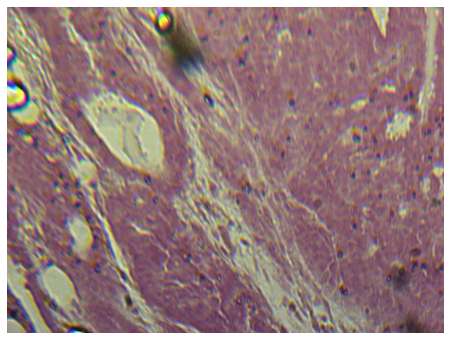

In [33]:
core.snap_image()
tagged_image = core.get_tagged_image()
rgb = True
if rgb == True:
    pixels = np.reshape(
        tagged_image.pix,
        newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"], 4],
        )
else:
    pixels = np.reshape(
        tagged_image.pix,
        newshape=[tagged_image.tags["Height"], tagged_image.tags["Width"]],
        )
pixels = pixels[:, :, 0:3]
pixels=np.flip(pixels, 2)
plt.figure(figsize=(8, 6))
imgplot = plt.imshow(exposure.rescale_intensity(pixels, out_range=(0, 1)))
plt.axis("off")
plt.show()

In [ ]:
### load libraries
bridge = Bridge()
core = bridge.get_core()
ij = imagej.init('fiji\\fiji\\Fiji.app')
Image.MAX_IMAGE_PIXELS = None  
core.set_timeout_ms(20000)

In [ ]:
### collect brightfield image
save_path = 'data/acquisition'
acq_name = 'slide-bf-test'
position_list, grid = generate_grid(config, mag='4x')
estimated_background_img = whole_slide_scan(config, save_path, acq_name, position_list=position_list, mda=False, core=core, estimate_background=True) # acquire 4x bf
stitching(config, ij, save_path=save_path, acq_name=acq_name, mda=False, position_list=position_list, flip_y=True, correction=True, background_image=bg_img) # stitch 4x bf